In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [55]:
DATA_PATH =  '../../../data/cluster/year/'
HISTORIC_DATA_PATH = '../../../data/cluster/historic/'
[f for f in os.listdir(DATA_PATH) if 'full' in f]

['X_test_full.csv',
 'X_train_full.csv',
 'X_valid_full.csv',
 'y_test_full.csv',
 'y_train_full.csv',
 'y_valid_full.csv']

In [3]:
X_train = pd.read_csv(DATA_PATH + 'X_train_full.csv')
X_valid = pd.read_csv(DATA_PATH + 'X_valid_full.csv')
X_test  = pd.read_csv(DATA_PATH + 'X_test_full.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train_full.csv')
y_valid = pd.read_csv(DATA_PATH + 'y_valid_full.csv')
y_test  = pd.read_csv(DATA_PATH + 'y_test_full.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_valid = X_valid.drop(['Unnamed: 0'], axis=1)
X_test  = X_test.drop(['Unnamed: 0'],  axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_valid = y_valid.drop(['Unnamed: 0'], axis=1)
y_test  = y_test.drop(['Unnamed: 0'],  axis=1)


print('train: X %s\t y%s' % (X_train.shape, y_train.shape))
print('valid: X %s\t y%s' % (X_valid.shape, y_valid.shape))
print('test:  X %s\t y%s' % (X_test.shape,  y_test.shape))

train: X (529623, 25)	 y(529623, 1)
valid: X (117694, 25)	 y(117694, 1)
test:  X (117694, 25)	 y(117694, 1)


In [4]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.23%
Percent presence in y_valid: 13.29%
Percent presence in y_test: 12.54%


In [5]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [6]:
np.isfinite(X_valid).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
studyArea                   True
elev_srtm30                 True
x                           True
y                           True
next_year_beetle            True
dtype: bool

In [7]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(527766, 25) (527766, 1)
(116732, 25) (116732, 1)
(117472, 25) (117472, 1)


In [8]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [9]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year'],  axis=1)

In [10]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [11]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [12]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [13]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1', 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.0001; (l1) Elapsed time: 0.01 minutes
(l2) Elapsed time: 0.05 minutes
Testing C = 0.0005; (l1) Elapsed time: 0.07 minutes
(l2) Elapsed time: 0.10 minutes
Testing C = 0.001; (l1) Elapsed time: 0.12 minutes
(l2) Elapsed time: 0.16 minutes
Testing C = 0.005; (l1) Elapsed time: 0.26 minutes
(l2) Elapsed time: 0.31 minutes
Testing C = 0.01; (l1) Elapsed time: 0.60 minutes
(l2) Elapsed time: 0.65 minutes
Testing C = 0.05; (l1) Elapsed time: 1.19 minutes
(l2) Elapsed time: 1.24 minutes
Testing C = 0.1; (l1) Elapsed time: 1.76 minutes
(l2) Elapsed time: 1.80 minutes
Testing C = 0.5; (l1) Elapsed time: 2.41 minutes
(l2) Elapsed time: 2.49 minutes
Testing C = 1; (l1) Elapsed time: 3.08 minutes
(l2) Elapsed time: 3.14 minutes


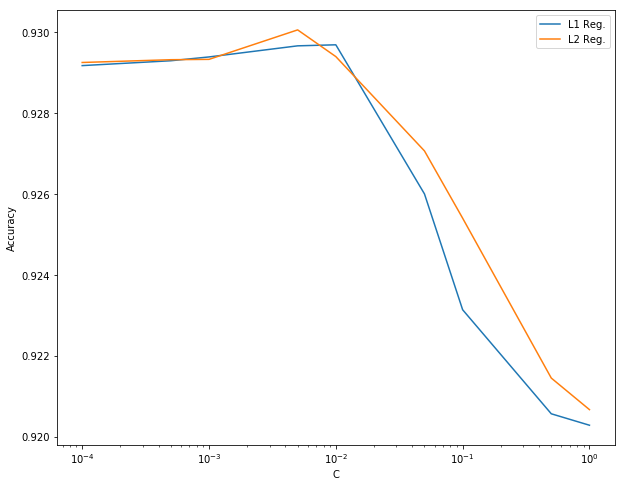

In [14]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [18]:
print(l1_mods)
print(l2_mods)

[0.92917109275948329, 0.9292910255970942, 0.92938525854093135, 0.92965082410992705, 0.92968509063495874, 0.92598430593153547, 0.92314018435390466, 0.92056162834526956, 0.92027036288250008]
[0.92924819244080459, 0.92931672549086797, 0.92932529212212589, 0.93005345577904941, 0.92939382517218927, 0.92706370147003392, 0.92540177500599663, 0.9214525579960936, 0.92070726107665424]


In [15]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1', 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.002; (l1) Elapsed time: 0.03 minutes
(l2) Elapsed time: 0.06 minutes
Testing C = 0.003; (l1) Elapsed time: 0.22 minutes
(l2) Elapsed time: 0.27 minutes
Testing C = 0.004; (l1) Elapsed time: 0.38 minutes
(l2) Elapsed time: 0.43 minutes
Testing C = 0.005; (l1) Elapsed time: 0.53 minutes
(l2) Elapsed time: 0.56 minutes
Testing C = 0.006; (l1) Elapsed time: 0.67 minutes
(l2) Elapsed time: 0.71 minutes
Testing C = 0.007; (l1) Elapsed time: 0.83 minutes
(l2) Elapsed time: 0.87 minutes
Testing C = 0.008; (l1) Elapsed time: 0.99 minutes
(l2) Elapsed time: 1.03 minutes
Testing C = 0.009; (l1) Elapsed time: 1.19 minutes
(l2) Elapsed time: 1.22 minutes


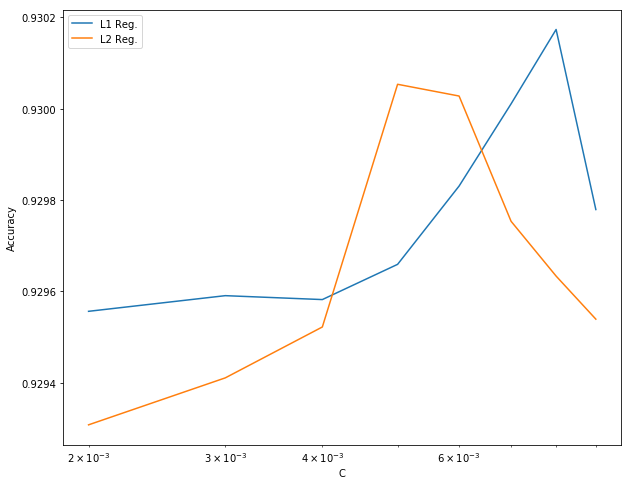

In [16]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [17]:
print(l1_mods)
print(l2_mods)

[0.9295565911660898, 0.9295908576911216, 0.92958229105986367, 0.92965939074118498, 0.92983072336634343, 0.9300106226227598, 0.93017338861666043, 0.92977932357879589]
[0.92930815885961005, 0.92941095843470511, 0.92952232464105811, 0.93005345577904941, 0.93002775588527564, 0.92975362368502212, 0.92963369084741121, 0.92953945790357395]


In [18]:
logistic_clf = LogisticRegression(C=0.008, penalty='l1')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.9320263552165623

In [19]:
def get_predictions_at_threshold(pred_ps, threshold):
    return 1 * (pred_ps >= threshold)

def threshold_plot(pred_ps, targets):
    thresholds = np.linspace(0, 1, 500)
    accuracies = []
    n = len(pred_ps)

    for threshold in thresholds:
        preds = get_predictions_at_threshold(pred_ps, threshold)
        accuracies.append((preds == targets).sum() / n)
        
    plt.plot(thresholds, accuracies);
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = max(accuracies)
    plt.plot([optimal_threshold, optimal_threshold], 
             [min(accuracies), max(accuracies)], 
             'r')
    plt.plot([0, 1], [optimal_accuracy, optimal_accuracy], 'r')
    plt.xlabel('Threshold for predicting "Renewal"')
    plt.ylabel('Accuracy')
    plt.show()
    return {'threshold': optimal_threshold, 'accuracy': optimal_accuracy}

[[  9.98470472e-01   1.52952822e-03]
 [  9.98607746e-01   1.39225377e-03]
 [  9.99036991e-01   9.63008768e-04]
 [  9.96796777e-01   3.20322277e-03]
 [  9.96858481e-01   3.14151945e-03]]


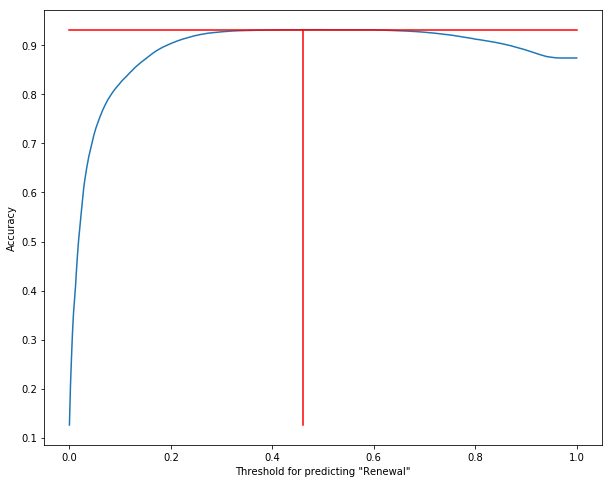

{'threshold': 0.46092184368737471, 'accuracy': 0.93209445655134837}


In [20]:
pred_ps = logistic_clf.predict_proba(X_test)
print(pred_ps[:5])
pred_ps = np.array([p[1] for p in pred_ps])
pred_ps[:5]

THRESHOLD = 0.5
preds = get_predictions_at_threshold(pred_ps, THRESHOLD)
preds[:5]

best_threshold = threshold_plot(pred_ps, y_test);
print(best_threshold)

In [21]:
preds = logistic_clf.predict(X_test)

In [22]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	10754		4004
        0	3981		98733
Accuracy:  0.932026355217
Precision: 0.729826942654
Recall:    0.728689524326
F1:        0.729257789984


In [23]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.46092184368737471)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	10818		3940
        0	4037		98677
Accuracy:  0.932094456551
Precision: 0.72823964995
Recall:    0.733026155306
F1:        0.730625063317


In [24]:
auc_metrics = util.get_auc(y_test, pred_ps)

AUC:       0.947320010033


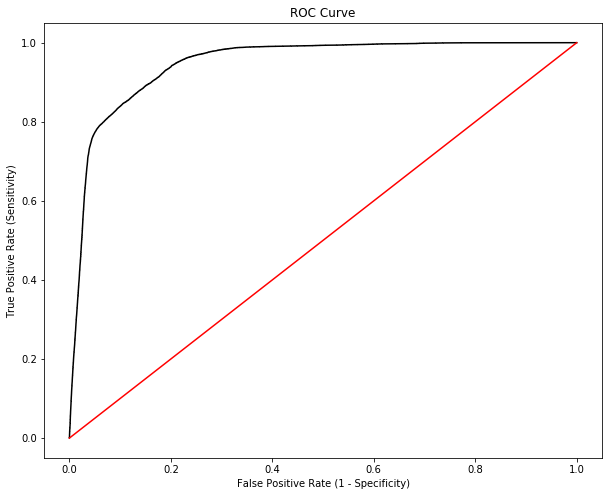

In [25]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [26]:
coefs = pd.DataFrame([[pred, coef] for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
                     columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
7,meanMaxTemp_Aug,1.853048
2,meanTemp_Aug,-1.423677
19,next_year_beetle,1.154666
10,vegetation,1.107910
17,lat,0.914469
1,meanTemp_AprAug,-0.864096
5,meanMinTemp_Jan,0.661427
16,elev_etopo1,0.512205
8,precip_meanAnnual,-0.369315
14,precip_growingSeason,0.310085


In [27]:
def column2matrix(dataframe, column, cell_dim=10000):
    '''                                                                          
    Convert a column from DataFrame df into a matrix representation with the     
    upper-left cell indexing beginning at [0, 0].                                
    It is expected that the DataFrame has columns x and y.                       
                                                                                 
    Args:                                                                        
    df: DataFrame: the source data                                               
    column: string: the column name to extract                                   
    cel_dim: numeric: the dimensions of each grid cell                           
                                                                                 
    Returns: np.ndarray (a 2D list; matrix)                                      
    '''
    df = dataframe.copy()
    x_min = df.x.min()
    y_min = df.y.min()
    df.x -= x_min
    df.y -= y_min
    xs = sorted(df.x.unique())
    ys = sorted(df.y.unique())
    matrix = np.array([[np.nan for y in range(len(ys))]
                       for x in range(len(xs))])

    for row in df.index:
        x, y, value = df.loc[row, ['x', 'y', column]]
        i = int((x - xs[0]) / cell_dim)
        j = int((y - ys[0]) / cell_dim)
        matrix[i, j] = value

    return matrix

In [28]:
full_test['preds'] = preds
full_test.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,elev_etopo1,lat,lon,studyArea,elev_srtm30,x,y,next_year_beetle,beetle,preds
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,52,30.505152,-116.039726,1,-2,-1550000.0,-2000000.0,0,0,0
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,17,30.523203,-115.938118,1,17,-1540000.0,-2000000.0,0,0,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,151,30.541141,-115.836475,1,74,-1530000.0,-2000000.0,0,0,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,500,30.558965,-115.734797,1,466,-1520000.0,-2000000.0,0,0,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,564,30.576676,-115.633085,1,568,-1510000.0,-2000000.0,0,0,0


In [42]:
def pred_plot(actual_matrix, pred_matrix, error_matrix, year):
    plt.subplot(131)
    imshow(np.rot90(actual_matrix));
    plt.title('%d Actual' % year);
    plt.subplot(132)
    imshow(np.rot90(pred_matrix));
    plt.title('%d Predicted' % year);
    plt.subplot(133)
    imshow(np.rot90(error_matrix));
    plt.title('%d Error' % year);

In [46]:
def make_actual_pred_and_error_matrices(data, year, plot=False):
    data_year = data.loc[data.year == year, :]
    actual_matrix = column2matrix(data_year, 'beetle')
    pred_matrix   = column2matrix(data_year, 'preds')
    error_matrix  = pred_matrix - actual_matrix
    
    if plot:
        pred_plot(actual_matrix, pred_matrix, error_matrix, year)
        
    return actual_matrix, pred_matrix, error_matrix

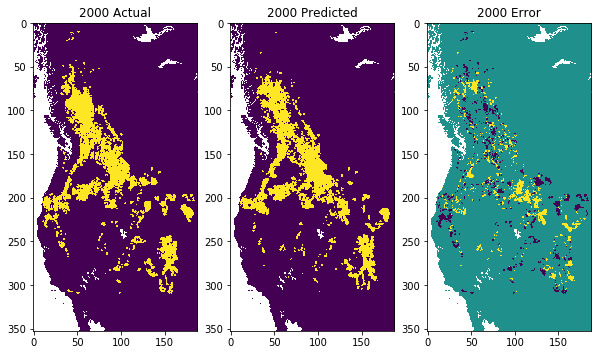

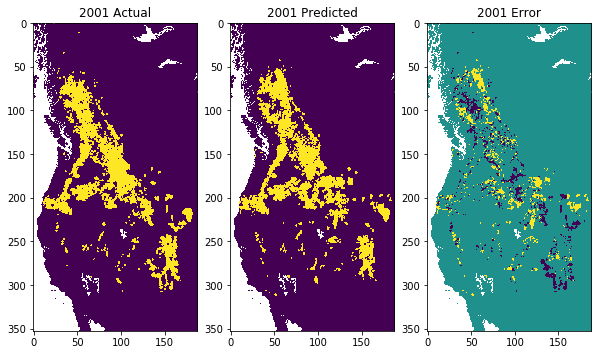

In [47]:
pred_years = [2000, 2001]
for year in pred_years:
    plt.figure();
    make_actual_pred_and_error_matrices(full_test, year, plot=True)

In [58]:
os.listdir(HISTORIC_DATA_PATH)

['.DS_Store', 'clean_1998.csv', 'clean_1999.csv']

In [240]:
def get_ranges(data, verbose=False):
    xrange = data.x.min(), data.x.max()
    yrange = data.y.min(), data.y.max()
    if verbose:
        print('x range:', xrange, '\ny range:', yrange)
    return xrange, yrange

In [287]:
x_range, y_range = get_ranges(full_test, verbose=True)

x range: (-2070000.0, -200000.0) 
y range: (-2000000.0, 1520000.0)


In [288]:
def mask_data(data, xrange, yrange, verbose=False):
    if verbose:
        print('Input data:')
        print_ranges(data)
    data = data.loc[(data.x >= xrange[0])
                    & (data.x <= xrange[1])
                    & (data.y >= yrange[0])
                    & (data.y <= yrange[1]), :]
    if verbose:
        print('Output data:')
        print_ranges(data)
    return data

In [289]:
def drop_nans(data, field, verbose=False):
    X = data.copy()
    X = X.loc[np.isnan(X[field]) == False, :]
    if verbose:
        print(X.shape, y.shape)
    return X

In [290]:
historic_years = range(1998, 2000)
year = 1999 # <- !
next_year_data = full_test.loc[full_test.year == 2000, :]

hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
hist_data = mask_data(hist_data, xrange, yrange, verbose=True)

Input data:
x range: (-5730000.0, 5000000.0) 
y range: (-4510000.0, 4480000.0)
Output data:
x range: (-2070000.0, -200000.0) 
y range: (-2000000.0, 1520000.0)


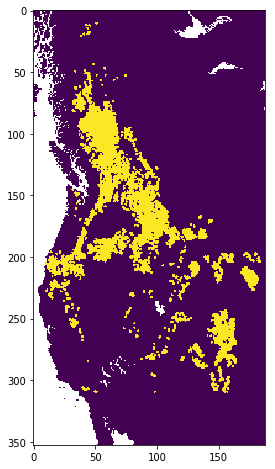

In [208]:
imshow(np.rot90(column2matrix(next_year_data, 'beetle')));

In [257]:
xy = next_year_data.apply(
    lambda row: str(row['x']) + str(row['y']), axis=1)

In [210]:
def find_extra_rows(data, xy):
    remove = []
    for row in data.index:
        data_xy = str(data.loc[row, 'x']) + str(data.loc[row, 'y'])
        if data_xy not in list(xy):
            remove.append(row)
    return remove

In [211]:
extras = find_extra_rows(hist_data, xy)
len(extras)

91

In [291]:
hist_data = hist_data.drop(extras, axis=0)
hist_data = hist_data.rename(
    columns={'precipPreious_OctSep': 'precipPrevious_OctSep'})
print(next_year_data.shape)

(58756, 27)


In [292]:
assert list(hist_data.x) == list(next_year_data.x)
assert list(hist_data.y) == list(next_year_data.y)

In [293]:
hist_data.index = next_year_data.index

In [294]:
print(hist_data.shape)
print(len(next_year_data['beetle']))

(58756, 22)
58756


In [295]:
#list(hist_data)

In [296]:
hist_data['next_year_beetle'] = next_year_data['beetle']
#hist_essential['next_year_beetle'] = next_year_data['beetle']
#imshow(np.rot90(column2matrix(hist_data, 'next_year_beetle')));
hist_essentials = pd.DataFrame(hist_data[predictors[0]])
for p in predictors[1:]:
    hist_essentials[p] = hist_data[p]

hist_essentials.head() 

,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,precip_JunAug,vegetation,precipPrevious_JunAug,precip_OctSep,precipPrevious_OctSep,precip_growingSeason,varPrecip_growingSeason,elev_etopo1,lat,lon,next_year_beetle
0,15.602269,17.043553,20.450920,4.002154,8.870124,5.713369,6.440989,26.268693,3.569788,4.673908,0,2.262533,273.108611,230.271149,11.946349,1.423028,52,30.505152,-116.039726,0
1,15.802161,17.255634,20.671149,4.107497,9.086548,5.811246,6.670581,26.478177,2.620590,2.958697,0,2.033822,256.542815,225.095741,10.556525,1.448678,17,30.523203,-115.938118,0
2,16.227222,17.887257,21.491630,3.915923,9.103102,5.610222,6.650329,27.738199,2.159113,6.173574,0,3.768936,248.747855,222.838494,9.174845,1.480682,151,30.541141,-115.836475,0
3,15.110016,16.998226,21.012175,2.579276,7.565246,4.211151,4.927163,27.898682,6.515173,29.650197,0,13.457667,360.251429,282.069357,18.777443,0.944476,500,30.558965,-115.734797,0
4,15.321903,17.448047,21.631819,2.254531,7.451563,3.817779,4.737033,28.959027,6.309332,35.674847,0,16.249203,353.847053,278.135072,17.231169,0.887878,564,30.576676,-115.633085,0


In [297]:
#print(hist_essential.shape)
#hist_essential = drop_nans(hist_essential, 'next_year_beetle')
#print(hist_essential.shape)

In [298]:
print(predictors)
print(list(hist_essentials))

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']
['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [300]:
hist_essentials = scaler.fit_transform(hist_essentials)

In [301]:
hist_data['preds'] = logistic_clf.predict(hist_essentials)

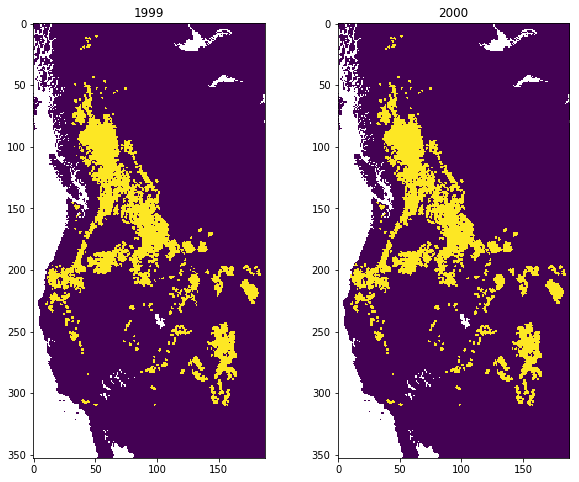

In [306]:
plt.subplot(121);
imshow(np.rot90(column2matrix(hist_data, 'preds')));
plt.title('1999');
plt.subplot(122);
imshow(np.rot90(column2matrix(hist_data, 'next_year_beetle')));
plt.title('2000');

In [318]:
m_1999 = column2matrix(hist_data, 'preds')
m_2000 = column2matrix(hist_data, 'next_year_beetle')

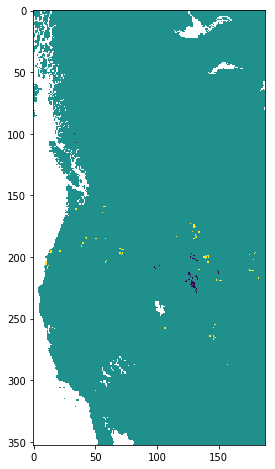

In [319]:
m_diff = m_2000 - m_1999
imshow(np.rot90(m_diff));

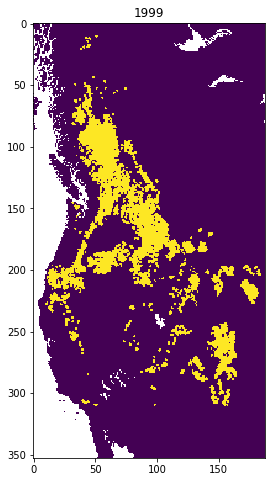

In [320]:
imshow(np.rot90(m_1999));
plt.title('1999');